In [2]:
# Import module for data manipulation
import pandas as pd
# Import module for linear algebra
import numpy as np
# Import module for data visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
# Import module for k-means
from sklearn.cluster import KMeans, DBSCAN
#import module k-prototype
from kmodes.kprototypes import KPrototypes
# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)
# Format scientific notation from Pandas
pd.set_option('display.max_columns', None)


# prepocessing sklearn
from sklearn.compose import make_column_transformer,make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE

#Pour la localisation du coude
from kneed import KneeLocator, DataGenerator as dg

In [3]:
df = pd.read_csv('data.csv')
df.rename(columns={"order_item_id": "orders", "product_id": "products", "seller_id":'sellers'}, inplace=True)
df['payment_installments']=df['payment_installments'].astype('int64')
df= df.drop(['customer_city','customer_state','customer_zip_code_prefix','seller_city','seller_state','customer_unique_id.1','order_purchase_timestamp','customer_unique_id'], axis=1)
df

,payment_type,product_category,payment_installments,orders,products,sellers,payment_value,review_score,price,freight_value,recency
0,credit_card,Home,8,1,1,1,141.90,5.0,129.90,12.00,112
1,credit_card,Health_Beauty,1,1,1,1,27.19,4.0,18.90,8.29,115
2,credit_card,Office_Supplies,8,1,1,1,86.22,3.0,69.00,17.22,538
3,credit_card,Technology,4,1,1,1,43.62,4.0,25.99,17.63,322
4,credit_card,Technology,6,1,1,1,196.89,5.0,180.00,16.89,289
...,...,...,...,...,...,...,...,...,...,...,...
91474,credit_card,Health_Beauty,10,2,2,2,4134.84,5.0,785.00,248.71,448
91475,credit_card,Baby,1,1,1,1,84.58,4.0,64.89,19.69,263
91476,credit_card,Automotive,1,1,1,1,112.46,5.0,89.90,22.56,569
91477,credit_card,Fashion_Accessories,5,1,1,1,133.69,5.0,115.00,18.69,120


In [4]:
from collections import Counter

outre_cat=list((Counter(df.product_category.value_counts().index.to_list())-Counter(df.product_category.value_counts().index.to_list()[0:10])).elements())
outre_cat
df.replace(outre_cat,"other", inplace=True)
df.product_category.value_counts()

Home                   22393
Technology             13021
Health_Beauty          11351
Fashion_Accessories     8533
Toys_Games              7941
Sports_Leisure          7101
other                   6291
Construction_Tools      5003
Automotive              3722
Office_Supplies         3370
Baby                    2753
Name: product_category, dtype: int64

In [50]:
transformer = make_column_transformer(
    (OneHotEncoder(sparse=False),make_column_selector(dtype_exclude=np.number)),
    (MinMaxScaler(),make_column_selector(dtype_include=np.number))
    )

In [51]:
df = transformer.fit_transform(df)
df=pd.DataFrame(df)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.000000,0.000000,0.001210,1.00,0.019164,0.029291,0.159712
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.000000,0.000000,0.000000,0.000161,0.75,0.002680,0.020235,0.164029
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.000000,0.000000,0.000701,0.50,0.010120,0.042033,0.772662
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.166667,0.000000,0.000000,0.000000,0.000311,0.75,0.003733,0.043034,0.461871
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.250000,0.000000,0.000000,0.000000,0.001714,1.00,0.026603,0.041227,0.414388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91474,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.416667,0.013514,0.013514,0.013514,0.037741,1.00,0.116444,0.607084,0.643165
91475,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.000000,0.000000,0.000000,0.000686,0.75,0.009510,0.048062,0.376978
91476,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.000000,0.000000,0.000000,0.000941,1.00,0.013224,0.055067,0.817266
91477,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.208333,0.000000,0.000000,0.000000,0.001135,1.00,0.016951,0.045621,0.171223


In [45]:
# Choose optimal K using Elbow method
inertia = []
for cluster in range(1, 10):
        kmeans = KMeans( n_clusters = cluster)
        kmeans.fit(df)
        inertia.append(kmeans.inertia_)
        print('Cluster initiation: {}'.format(cluster))



Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


Text(0, 0.5, 'Cout du modèle (inertia)')

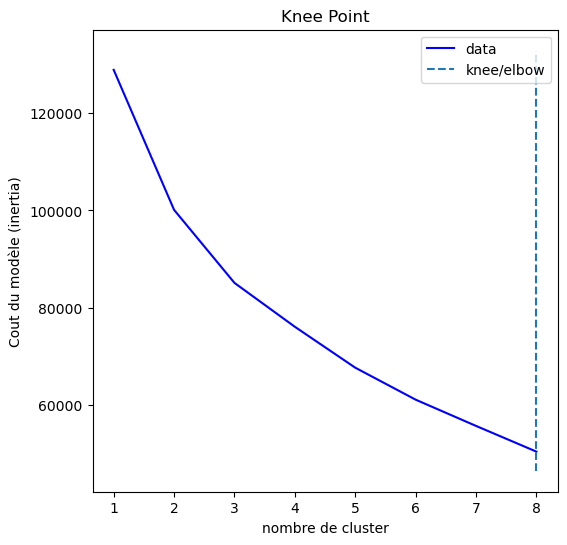

In [46]:
x,y = range(1,9),inertia[:-1]
kl = KneeLocator(x,y, curve='convex')
kl.plot_knee()
plt.xlabel('nombre de cluster')
plt.ylabel('Cout du modèle (inertia)')

In [52]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df)
kmeans.predict(df)

array([2, 1, 1, ..., 1, 1, 1], dtype=int32)

In [326]:
df = pd.read_csv('data.csv')
df.rename(columns={"order_item_id": "orders", "product_id": "products", "seller_id":'sellers'}, inplace=True)
df['payment_installments']=df['payment_installments'].astype('int64')
df= df.drop(['customer_city','customer_state','customer_zip_code_prefix','seller_city','seller_state','customer_unique_id.1','order_purchase_timestamp','customer_unique_id'], axis=1)
df

,payment_type,product_category,payment_installments,orders,products,sellers,payment_value,review_score,price,freight_value,recency
0,credit_card,Home,8,1,1,1,141.90,5.0,129.90,12.00,112
1,credit_card,Health_Beauty,1,1,1,1,27.19,4.0,18.90,8.29,115
2,credit_card,Office_Supplies,8,1,1,1,86.22,3.0,69.00,17.22,538
3,credit_card,Technology,4,1,1,1,43.62,4.0,25.99,17.63,322
4,credit_card,Technology,6,1,1,1,196.89,5.0,180.00,16.89,289
...,...,...,...,...,...,...,...,...,...,...,...
91474,credit_card,Health_Beauty,10,2,2,2,4134.84,5.0,785.00,248.71,448
91475,credit_card,Baby,1,1,1,1,84.58,4.0,64.89,19.69,263
91476,credit_card,Automotive,1,1,1,1,112.46,5.0,89.90,22.56,569
91477,credit_card,Fashion_Accessories,5,1,1,1,133.69,5.0,115.00,18.69,120


In [114]:
a = FunctionTransformer(func=np.log1p)
preprocessing = make_column_transformer((a,make_column_selector(dtype_include=np.number)),remainder='passthrough')
log=preprocessing.fit_transform(df)
log[0]

array([2.1972245773362196, 0.6931471805599453, 0.6931471805599453,
       0.6931471805599453, 4.9621450849358215, 1.791759469228055,
       4.874433672915854, 2.5649493574615367, 4.727387818712341,
       'credit_card', 'Home'], dtype=object)

In [109]:
kprototype = KPrototypes(n_jobs = -1, n_clusters =4, init = 'Huang', random_state = 0)
kprototype.fit_predict(log, categorical = [9,10])

array([0, 2, 0, ..., 0, 0, 0], dtype=uint16)

In [119]:
transformer = make_column_transformer(
    (OneHotEncoder(sparse=False),make_column_selector(dtype_exclude=np.number)),
    (a,make_column_selector(dtype_include=np.number))
    )



In [120]:

transform_array=transformer.fit_transform(df)

df_log=pd.DataFrame(transform_array)

pipe_tsne = make_pipeline(transformer,TSNE()) 
array_tsne=pipe_tsne.fit_transform(df_log)

df_tsne=pd.DataFrame(array_tsne,columns=['f1','f2'])
df_tsne['cluster_labels']=pd.Series(kprototype.labels_)

df_tsne.groupby('cluster_labels').describe()

f1                                               \
                  count       mean        std         min        25%   
cluster_labels                                                         
0               36182.0  -7.407209  61.744591 -127.949379 -62.205286   
1               14100.0 -17.476286  55.634636 -114.663200 -59.998670   
2               27226.0  18.016830  59.660580 -127.916985 -27.554313   
3               13971.0   1.051694  55.229038 -125.036728 -44.307789   

                                                       f2             \
                      50%        75%         max    count       mean   
cluster_labels                                                         
0              -10.779665  37.292496  131.431152  36182.0   6.669052   
1              -20.381799  18.067651  131.352600  14100.0   4.695980   
2               26.440255  63.176668  132.736603  27226.0 -13.650376   
3               -0.729433  48.666428  130.325333  13971.0   4.909513   

                                                                        \
                      std         min        25%        50%        75%   
cluster_labels                                                           
0               60.210869 -120.301292 -35.771955   5.894869  54.464774   
1               49.417736 -111.139824 -29.744415   6.527676  46.538960   
2               67.670456 -134.997467 -69.465002 -21.217380  34.674914   
3               58.657417 -129.261826 -41.621489   1.877501  57.318092   

                            
                       max  
cluster_labels              
0               127.680733  
1               119.543457  
2               125.887268  
3               113.913689

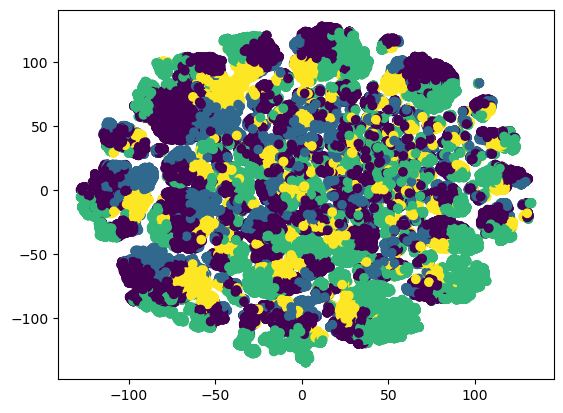

In [121]:
plt.scatter(df_tsne.f1,df_tsne.f2,c=df_tsne.cluster_labels)
plt.show()

In [124]:
# a = FunctionTransformer(func=np.log1p)
# preprocessing = make_column_transformer((a,make_column_selector(dtype_include=np.number)),remainder='passthrough')
# log=preprocessing.fit_transform(df)

# kprototype = KPrototypes(n_jobs = -1, n_clusters =4, init = 'Huang', random_state = 0)
# kprototype.fit_predict(log, categorical = [9,10])

# transformer = make_column_transformer(
#     (OneHotEncoder(sparse=False),make_column_selector(dtype_exclude=np.number)),
#     (a,make_column_selector(dtype_include=np.number))
#     )

# transform_array=transformer.fit_transform(df)

# df_transform=pd.DataFrame(transform_array)


# pca = PCA(n_components=0.95)
# df_pca=pd.DataFrame(pca.fit_transform(df_transform))

# df_pca['cluster_labels']=pd.Series(kprototype.labels_)

# df_pca.groupby('cluster_labels').describe()

# plt.scatter(df_pca.iloc[:,0],df_pca.iloc[:,1],c=df_pca.cluster_labels)
# plt.show()

f1                                                    \
                  count      mean       std       min       25%       50%   
cluster_labels                                                              
0               36182.0  0.269302  0.479563 -0.739226 -0.127198  0.259433   
1               14100.0  2.039527  0.789750  0.674333  1.438097  1.820902   
2               27226.0 -1.330522  0.565643 -3.979125 -1.716944 -1.242614   
3               13971.0 -0.162940  0.900872 -4.032302 -0.772653 -0.124715   

                                         f2                                \
                     75%       max    count      mean       std       min   
cluster_labels                                                              
0               0.654620  1.385133  36182.0 -0.387238  0.488569 -1.434815   
1               2.451766  6.731699  14100.0 -0.082386  0.747309 -1.439737   
2              -0.857410 -0.399303  27226.0 -0.296800  0.563275 -1.405327   
3               0.492475  3.005466  13971.0  1.664403  0.687679  0.496728   

                                                        
                     25%       50%       75%       max  
cluster_labels                                          
0              -0.795234 -0.435813 -0.025884  0.844789  
1              -0.653564 -0.203596  0.360255  3.619074  
2              -0.747072 -0.359895  0.083994  2.205270  
3               1.080961  1.580487  2.090979  4.498288

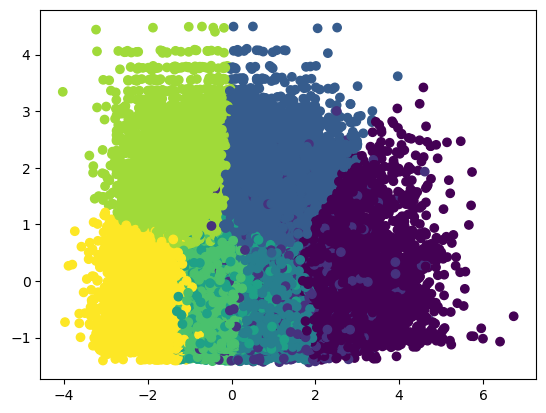

In [6]:
func_log = FunctionTransformer(func=np.log1p)
func_abs=FunctionTransformer(func=np.abs)

pipe_num= make_pipeline(func_abs,func_log)

transformer = make_column_transformer(
    (OneHotEncoder(sparse=False),make_column_selector(dtype_exclude=['float','int'])),
    (pipe_num,make_column_selector(dtype_include=['float','int']))
    )

pipe_pca= make_pipeline(transformer,PCA(n_components=0.95))

df_acp=pd.DataFrame(pipe_pca.fit_transform(df))


clustering =KMeans(n_clusters=8).fit(df_acp)
df_acp['cluster_labels']=pd.Series(clustering.labels_)


plt.scatter(df_acp.iloc[:,0],df_acp.iloc[:,1],c=df_acp.cluster_labels)
plt.show()

In [7]:
df_num=df[['payment_installments','orders','products','sellers','payment_value','review_score','price','freight_value','recency']]

mms=MinMaxScaler(feature_range=(1,5))

num_cols= df.select_dtypes(include='number').columns
df_num['cluster_labels']=pd.Series(clustering.labels_)

list_agg = {}
for col in num_cols:
    list_agg[f'{col}'] = 'median'

df_mean=df_num.groupby('cluster_labels').agg(list_agg)


df_mms=pd.DataFrame(mms.fit_transform(df_mean),columns=['payment_installments','orders','products','sellers','payment_value','review_score','price','freight_value','recency'])
df_mms


/tmp/ipykernel_54326/3797345276.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['cluster_labels']=pd.Series(clustering.labels_)


,payment_installments,orders,products,sellers,payment_value,review_score,price,freight_value,recency
0,5.0,1.0,1.0,1.0,5.000000,5.0,5.000000,5.000000,4.159664
1,1.8,5.0,5.0,5.0,3.995630,1.0,1.412780,1.562699,4.487395
2,2.6,1.0,1.0,1.0,1.947547,5.0,1.925780,2.649905,1.050420
3,3.4,1.0,1.0,1.0,1.967023,5.0,2.101449,2.122852,5.000000
4,1.0,1.0,1.0,1.0,1.546256,5.0,1.531313,1.654360,4.882353
5,1.8,1.0,1.0,1.0,1.314327,5.0,1.310935,1.274984,4.831933
6,1.0,1.0,1.0,1.0,1.154524,5.0,1.136056,1.287715,1.000000
7,1.0,1.0,1.0,1.0,1.000000,5.0,1.000000,1.000000,4.747899


In [337]:
# Créer une figure en radar pour chaque cluster
fig = go.Figure()

for cluster, row in df_mms.iterrows():
    values = row.values.tolist()
    

    

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=num_cols,
        fill='toself',
        name=f'Cluster {cluster}'
    ))

# Mettre en forme la figurenum_cols,
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 5]
        ),
    ),
    showlegend=True,
    width=780,
    height=780

)

# Afficher la figure
fig.show()
figsize = (60,60)

In [316]:
# func_log = FunctionTransformer(func=np.log1p)
# func_abs=FunctionTransformer(func=np.abs)

# pipe_num= make_pipeline(func_abs,func_log)

# transformer = make_column_transformer(
#     (OneHotEncoder(sparse=False),make_column_selector(dtype_exclude=['float','int'])),
#     (pipe_num,make_column_selector(dtype_include=np.number)),remainder='passthrough')


# pipe_tsne = make_pipeline(transformer,TSNE()) 
# array_tsne=pipe_tsne.fit_transform(df)

# kprototype = KPrototypes(n_jobs = -1, n_clusters =4, init = 'Huang', random_state = 0)
# kprototype.fit_predict(array_tsne, categorical = [9,10])

# df_tsne=pd.DataFrame(array_tsne,columns=['f1','f2'])
# df_tsne['cluster_labels']=pd.Series(kprototype.labels_)

# plt.scatter(df_tsne.f1,df_tsne.f2,c=df_tsne.cluster_labels)
# plt.show()

AssertionError: All columns are categorical, use k-modes instead of k-prototypes.

In [19]:
dummy_product=pd.get_dummies(df.product_category,sparse=False)
prod_col=dummy_product.columns.to_list()

list_agg = {}
for col in prod_col:
    list_agg[f'{col}'] = 'sum'

dummy_product['cluster_labels']=pd.Series(clustering.labels_)

df_cat=dummy_product.groupby('cluster_labels').agg(list_agg)
df_mms_cat=pd.DataFrame(mms.fit_transform(df_cat), columns=prod_col)
df_mms_cat

,Automotive,Baby,Construction_Tools,Fashion_Accessories,Health_Beauty,Home,Office_Supplies,Sports_Leisure,Technology,Toys_Games,other
0,2.324547,1.795812,1.507865,2.097168,1.787416,1.000000,1.000000,1.000000,1.000000,1.842625,1.486815
1,1.000000,1.000000,1.993258,1.000000,1.000000,2.271028,1.342105,1.412184,1.082995,1.000000,1.000000
2,2.390445,2.109948,2.033708,2.325930,2.402247,1.855236,1.668421,1.401815,1.088128,1.449926,2.058824
3,5.000000,4.078534,2.914607,5.000000,3.887191,3.127789,5.000000,4.141931,1.798289,5.000000,3.137931
4,2.897858,2.542757,2.964045,2.550250,2.414831,2.419035,2.800000,2.988334,1.615187,2.730636,2.659229
5,4.321252,5.000000,5.000000,4.320378,5.000000,5.000000,3.894737,5.000000,2.062674,4.518500,5.000000
6,3.056013,2.193717,1.134831,1.464187,1.960000,1.656113,1.031579,1.653273,1.400428,1.282190,2.472617
7,3.734761,2.075044,1.000000,1.939478,2.591011,1.950601,1.294737,2.402463,5.000000,2.357671,3.275862


In [20]:
# Créer une figure en radar pour chaque cluster
fig = go.Figure()

for cluster, row in df_mms_cat.iterrows():
    values = row.values.tolist()
    

    

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=prod_col,
        fill='toself',
        name=f'Cluster {cluster}'
    ))

# Mettre en forme la figurenum_cols,
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 5]
        ),
    ),
    showlegend=True,
    width=780,
    height=780

)

# Afficher la figure
fig.show()
figsize = (60,60)